In [ ]:
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub

     |████████████████████████████████| 380.8 MB 37 kB/s 
     |████████████████████████████████| 449 kB 44.6 MB/s 
     |████████████████████████████████| 3.8 MB 47.6 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=3aa440a10c9de33c9e9f51755ca4971891e04a0a2cc818a9b60842862429515f
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow import keras,lite


For better data visualization we'll use [Pandas library](https://pandas.pydata.org/).

In [ ]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [ ]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Hub version:  0.12.0
Eager mode:  True
GPU is NOT AVAILABLE


### Dataset preparation

 For this example you will use the TensorFlow flowers dataset.

In [ ]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [ ]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [ ]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax'),
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Train for 92.0 steps, validate for 23.0 steps
Epoch 1/20
92/92 [==============================] - 186s 2s/step - loss: 0.8100 - acc: 0.6931 - val_loss: 0.4605 - val_acc: 0.8427
Epoch 2/20
92/92 [==============================] - 181s 2s/step - loss: 0.4012 - acc: 0.8602 - val_loss: 0.3771 - val_acc: 0.8755
Epoch 3/20
92/92 [==============================] - 181s 2s/step - loss: 0.3155 - acc: 0.8969 - val_loss: 0.3570 - val_acc: 0.8782
Epoch 4/20
92/92 [==============================] - 181s 2s/step - loss: 0.2686 - acc: 0.9064 - val_loss: 0.3424 - val_acc: 0.8933
Epoch 5/20
92/92 [==============================] - 181s 2s/step - loss: 0.2376 - acc: 0.9234 - val_loss: 0.3384 - val_acc: 0.8837
Epoch 6/20
92/92 [==============================] - 181s 2s/step - loss: 0.2157 - acc: 0.9309 - val_loss: 0.3217 - val_acc: 0.8933
Epoch 7/20
92/92 [==============================] - 181s 2s/step - loss: 0.1991 - acc: 0.9371 - val_loss: 0.3187 - val_acc: 0.8919
Epoch 8/20
92/92 [===================

In [ ]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

23/23 [==============================] - 37s 2s/step - loss: 0.3436 - acc: 0.8960


In [ ]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.33
Final accuracy: 87.14%


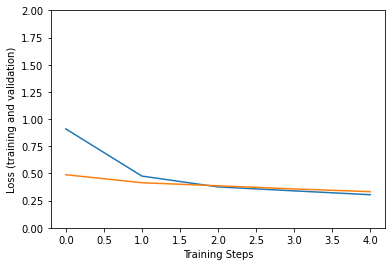

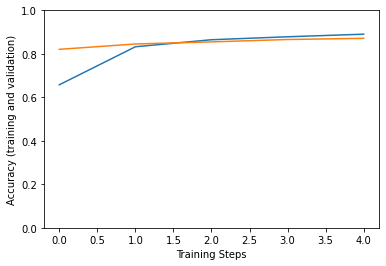

In [ ]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

### Export your model

We'll save our model as TensorFlow SavedModel format. After that we'll do inference on reloaded model, so if you come with a model already trained, it'll be easier to inspect it.

In [ ]:
# FLOWERS_SAVED_MODEL = "flowers.h5"
# tf.saved_model.save(model, FLOWERS_SAVED_MODEL)
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tfmodel)